## Extract the surface area of Lake Jindabyne for each 1m interval of depth
This notebook takes the gauge data of TLake Jindabyne from a csv file (that I got from Water Data Online) and links it to wofs. This allows an image of the reservoir to be generated at each 1m interval of depth. The aim is to get the surface area of Lake Jindabyne in m2 for each 1m depth interval. I've got as far as generating x images of Lake Jindabyne at 1m intervals from the lowest it's ever been to the highest it's ever been. I haven't extracted surface area in m2 yet for each interval but I want to do that in this notebook eventually. 

In [1]:
import sys
import os
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.gridspec as gs
import matplotlib.pyplot as plt
from matplotlib import pyplot
import rasterio
import datacube
from datacube.utils import geometry 
from datacube.utils.geometry import CRS
from datacube.utils import masking
from datacube.helpers import ga_pq_fuser, write_geotiff
#from digitalearthau.utils import wofs_fuser
sys.path.append('../10_Scripts/')
#import DEAPlotting, DEADataHandling
import warnings
warnings.filterwarnings('ignore', module='datacube')
%load_ext autoreload
%autoreload 2

Enter csv file and buffer

In [2]:
csv = 'Jindabyne.csv'

## use lookup tables to get the reservoir centroid lat & lon and recommended buffer

In [3]:
#Get the ID of the gauge so you can get the centroid of the reservoir from the look up table
gauge_number_df = pd.read_csv(csv, nrows=1, escapechar='#')
column2 = list(gauge_number_df)[1]
gauge_number_df = gauge_number_df.rename(columns = {column2 : 'gauge_ID'})
ID = gauge_number_df.at[0, 'gauge_ID']
ID_str = ID.astype(str)

buffer_factor = 2848.12 #I decided this number because 7000 was a good buffer for Tantangara. Use this number for all reservoirs.
ID_area = pd.read_csv('../ID_area_lookup') #buffer lookup table
ID_area['buffer'] = ID_area['Area_calc']/buffer_factor
ID_area = ID_area.set_index(['gauge_ID'])
buffer = ID_area.at[ID_str, 'buffer']
buffer = buffer.max()

loc_lookup = pd.read_csv('../gauge_lookup_table') #centroid lookup table
loc_lookup = loc_lookup.set_index(['gauge_ID'])

lat = loc_lookup.at[ID_str, 'lat']
lon = loc_lookup.at[ID_str, 'lon']

print('The ID number of this gauge is:', ID_str)
print('The recommended buffer is:', buffer)
print('the location of the middle of the reservoir is:', lat, lon)

The ID number of this gauge is: 222540
The recommended buffer is: 9280.180750811061
the location of the middle of the reservoir is: -36.37440063146142 148.6256083203337


## Read csv
This cell gets the location of the gauge (if you want to use that instead of the centroid location), rearranges it into a depth duration curve and makes 1m intervals between the lowest gauge value ever and the highest gauge value ever. Using the location of the gauge isn't the best location, the location should be the centroid of the reservoir which is the lat and lon in the 'join_matched' shapefile.

In [5]:

#Make depth duration curve
gauge_data = pd.read_csv(csv,
                error_bad_lines = False, skiprows=9, escapechar='#',
                         parse_dates=['Timestamp'], 
                         index_col=('Timestamp'),
                        date_parser=lambda x: pd.to_datetime(x.rsplit('+', 1)[0])) #Robbi wrote this line
gauge_data = gauge_data.dropna()
gauge_data = gauge_data.sort_values('Value')
gauge_data['rownumber'] = np.arange(len(gauge_data))
gauge_data['Exceedence'] = (1-(gauge_data.rownumber/len(gauge_data)))*100
gauge_data = gauge_data.drop(columns=['Interpolation Type', 'Quality Code'])
depth_integers = gauge_data.astype(np.int64)
max_depth = depth_integers.Value.max()
min_depth = depth_integers.Value.min()
integer_array = depth_integers.Value.unique()
integer_list = integer_array.tolist()
print('there are this many meter intervals for depth:', len(integer_list))
print('the gauge location is:', lat, lon)

there are this many meter intervals for depth: 16
the gauge location is: -36.37440063146142 148.6256083203337


## Merge satellite data with gauge data
We do this so we can call satellite data by gauge level

In [6]:
#Dask loading wofs_albers data
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer, x + buffer),
         'y': (y - buffer, y + buffer),    
         'time': ('1980-01-01', '2019-08-22'), 
         'crs': 'EPSG:3577'} 
dc = datacube.Datacube(app='dc-WOfS')
wofs_albers= dc.load(product = 'wofs_albers', dask_chunks = {}, group_by='solar_day', **query)
gauge_data_xr = gauge_data.to_xarray()
merged_data = gauge_data_xr.interp(Timestamp=wofs_albers.time)

## Make an outline of the max reservoir extent
I'm trying to copy the idea of the Digital Earth Africa Demo - Water Body Surface Extents notebook that Fang sent me, where you make a shape of the reservoir extent depending on the fullest it's ever been and then you can overlay the surface area of the reservoir at each meter of depth.  I can plot what it looks like at the highest depth, but I can't make it a cut-out shape, you know what I mean? I tried to copy the DE Africa notbook but anyway I can't make it work yet. 

In [7]:
#Get the max meter of depth and plot it. This is the outline of the reservoir area.
lower = max_depth-3
max_level = merged_data.where((merged_data.Value < max_depth) & 
                                    (merged_data.Value > lower), 
                                    drop=True)
date_list = max_level.time.values
print(f'You are about to load {max_level.time.shape[0]} satellite passes')

You are about to load 49 satellite passes


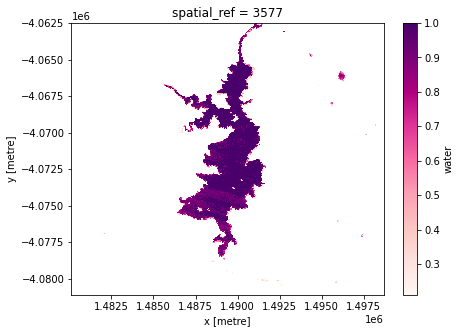

In [8]:
# Load the passes that happened during the specified flow parameters
specified_passes = wofs_albers.sel(time=date_list).compute()
# Calculate the number of cloudy pixels per timestep
cc = masking.make_mask(specified_passes.water, cloud=True)
ncloud_pixels = cc.sum(dim=['x', 'y'])

# Calculate the total number of pixels per timestep
npixels_per_slice = (specified_passes.water.shape[1] * 
                     specified_passes.water.shape[2])
# Calculate the proportion of cloudy pixels
cloud_pixels_fraction = (ncloud_pixels / npixels_per_slice)
clear_specified_passes = specified_passes.water.isel(
    time=cloud_pixels_fraction < 0.2)
wet = masking.make_mask(clear_specified_passes, wet=True).sum(dim='time')
dry = masking.make_mask(clear_specified_passes, dry=True).sum(dim='time')
clear = wet + dry
frequency = wet / clear
frequency = frequency.fillna(0)  
frequency = frequency.where(frequency != 0)  

wet_shape = frequency.where(frequency > 0.2)
#Plotting the image
wet_shape.plot(figsize = (7,5), cmap='RdPu')

## Load passes by meter intervals
In this cell I loop load an image of Tantangara Dam at every one meter depth interval. This takes a while to run and matplotlib keeps giving warnings because there are more than 20 images being plotted at once (in fact there's 20 because there's 20 1m intervals). But it totally works! I just need to somehow extract surface area as a number for each of these plots. 

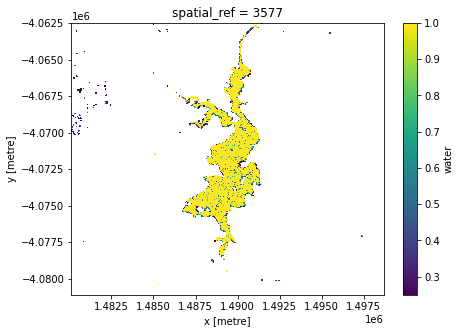

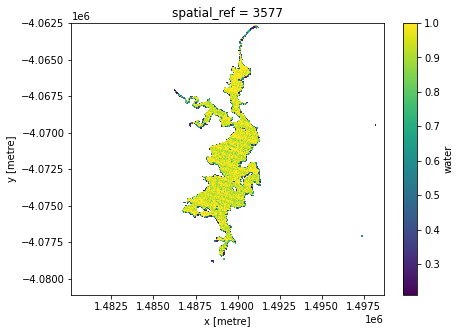

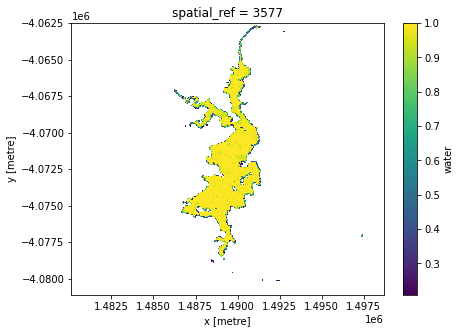

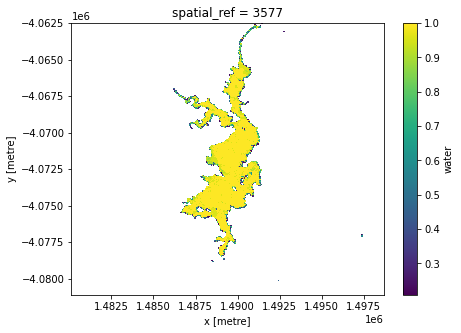

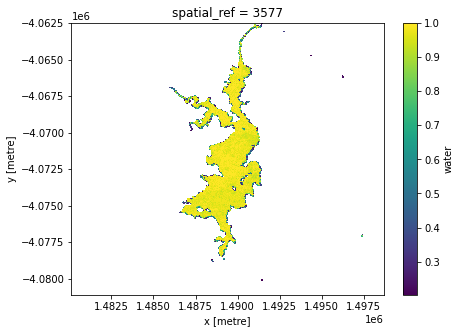

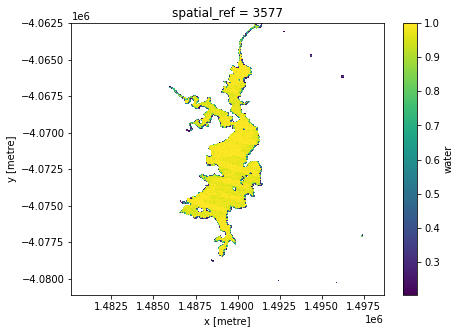

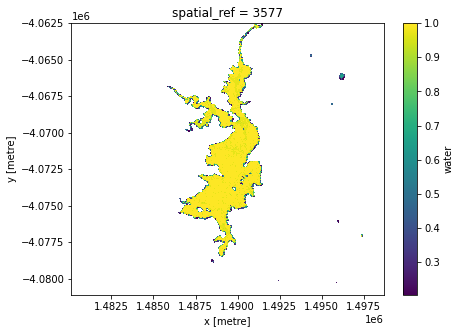

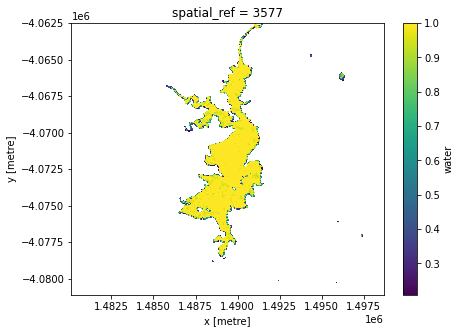

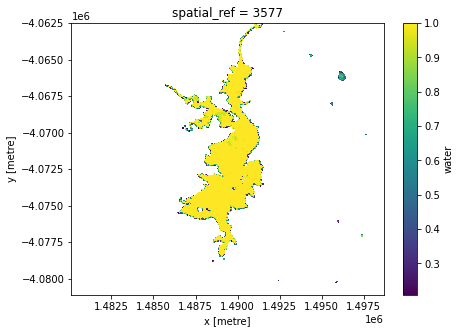

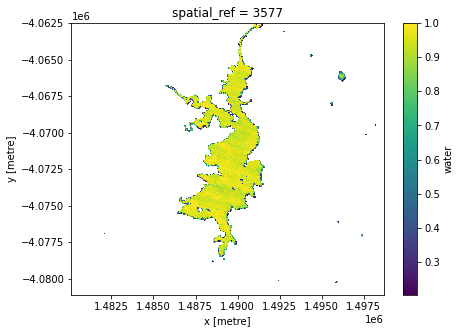

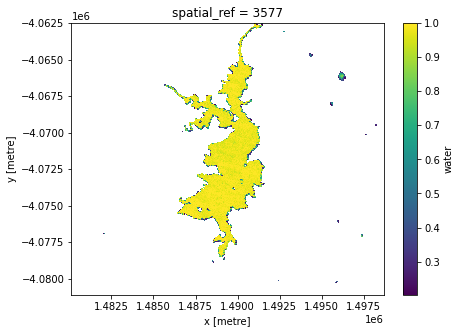

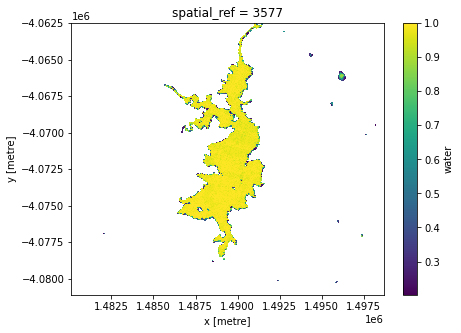

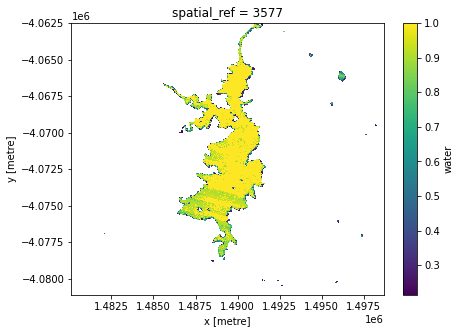

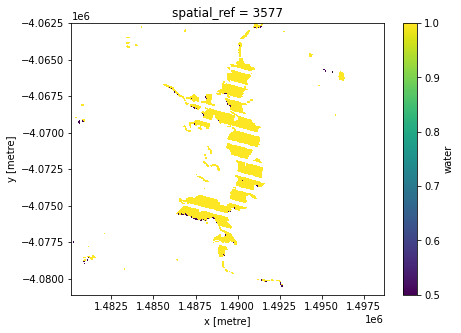

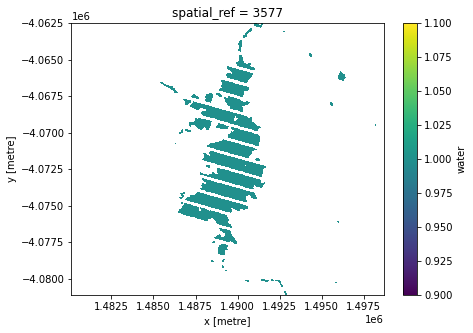

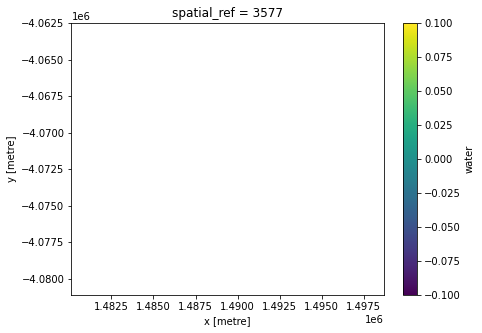

In [9]:
for i in integer_list:
    specified_level = merged_data.where((merged_data.Value > i) & 
                                    (merged_data.Value < i+1), drop=True)
    date_list = specified_level.time.values
    specified_passes = wofs_albers.sel(time=date_list).compute()
    #cloudmask
    cc = masking.make_mask(specified_passes.water, cloud=True)
    ncloud_pixels = cc.sum(dim=['x', 'y'])
    # Calculate the total number of pixels per timestep
    npixels_per_slice = (specified_passes.water.shape[1] * 
                         specified_passes.water.shape[2])
    cloud_pixels_fraction = (ncloud_pixels / npixels_per_slice)
    clear_specified_passes = specified_passes.water.isel(
        time=cloud_pixels_fraction < 0.2)
    wet = masking.make_mask(clear_specified_passes, wet=True).sum(dim='time')
    dry = masking.make_mask(clear_specified_passes, dry=True).sum(dim='time')
    clear = wet + dry
    frequency = wet / clear
    frequency = frequency.fillna(0)  
    frequency = frequency.where(frequency != 0)  #makes dry parts white
    wet_shape = frequency.where(frequency > 0.2)

    #Plotting the image
    wet_shape.plot(figsize = (7,5))